## Load Libraries

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
%matplotlib inline
import random
random.seed(30)
from sklearn.utils import compute_sample_weight
import pickle
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

In [2]:
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)    

def save_object(filename, object):
    with open(filename, 'wb') as filehandler:
        pickle.dump(object, filehandler)
        print('Saved to ' ,filename)
def read_object(filename):
    with open(filename, 'rb') as filehandler:
        pickle.load(filehandler)
        

## Data Preprocess

In [3]:
def load_data(filename):
    from sklearn.utils import Bunch
    def decodeText(text):
        if type(text) != str:
            try:
                text = text.decode('utf-8')
            except:
                text = text.decode('latin-1')
        text = text.rstrip()
        return text.split('@')
    
    contexts, labels = [], []
    with open(filename, 'rb') as f:
        text = f.readlines()
    
    for t in tqdm(text):
        context, label = decodeText(t)
        contexts += [context]
        if label == 'positive':
            target = 1
        elif label == 'negative':
            target = -1
        elif label == 'neutral':
            target = 0
        else:
            raise('ERROR: ' + label)
        labels += [target]
        
#    return Bunch(contexts = contexts, labels = np.array(labels))
    return pd.DataFrame(zip(contexts, labels), columns = ['contexts','labels'])
def preprocessing(data):
    """
    input:
        - data is a dataframe with columns contexts as series of text
    output:
        - preprocessed dataframe
    """
    import string
    import re
    from nltk import word_tokenize
    from nltk.corpus import stopwords
    from nltk.stem.wordnet import WordNetLemmatizer
    
    # lowercase 
    data.contexts = data.contexts.apply(lambda x: ' '.join(word.lower() for word in x.split()))
    
    data.contexts = data.contexts.apply(lambda x: re.sub(r"don't", "do not", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"aren't", "are not", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"couldn't", "could not", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"didn't", "did not", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"doesn't", "does not", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"hadn't", "had not", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"hasn't", "has not", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"haven't", "have not", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"isn't", "is not", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"mightn't", "might not", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"mustn't", "must not", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"needn't", "need not", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"shan't", "shall not", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"wasn't", "was not", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"weren't", "were not", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"won't", "will not", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"wouldn't", "would not", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"shouldnt", "should not", x))
    
    # remove numbers
    data.contexts = data.contexts.apply(lambda x: re.sub(r"\d+", '', x))
    # remove punctuations
    # data.contexts = data.contexts.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"what's", "what is ", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"\'s", " ", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"\'ve", " have ", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"i'm", "i am ",  x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"\'re", " are ",  x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"\'d", " would ", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"!", " ! ", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"\/", " ", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"\^", " ^ ", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"\+", " + ", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"\-", " - ", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"(\d+)(k)", r"\g<1>000", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r":", " : ", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r" e g ", " eg ", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r" b g ", " bg ",x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r" u s ", " american ", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"\0s", "0",  x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r" 9 11 ", "911",  x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"e - mail", "email", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"j k", "jk", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"\s{2,}", " ", x))
    
    




    # remove whitespace
    data.contexts = data.contexts.apply(lambda x: x.strip())
    # tokenization
    data.contexts = data.contexts.apply(word_tokenize)
    # remove stop words
    #stop_words = stopwords.words('english')
    #for word in ['above', 'below','up','down', 'more', 'not']:
    #    stop_words.remove(word)
    #data.contexts = data.contexts.apply(lambda x: [word for word in x if word not in stop_words])
    # stemming
    lemmatizer = WordNetLemmatizer()
    data.contexts = data.contexts.apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [4]:
data3 = load_data('Sentences_AllAgree.txt')
preprocessing(data3)

100%|██████████| 2264/2264 [00:00<00:00, 476606.32it/s]


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data3.contexts, data3.labels,test_size = 0.2, shuffle = True, random_state = 1)
X_dev, X_test, y_dev, y_test = train_test_split(X_test, y_test,test_size = 0.5, shuffle = True, random_state = 1)

In [6]:
# # Train, dev, test split

# def train_dev_test_split(data, train_dev_split_frac = 0.7, shuffle = True):
#     """
#     input:
#         - data is a dataframe with column contexts as X and column labels as y
#         - train_dev_split_frac
#     return
#         - X_train, y_train, X_dev, y_dev, X_test, y_test
#     """
#     from sklearn.utils import shuffle
#     if shuffle:
#         datda = shuffle(data)
#     dev_idx = int(len(data) * train_dev_split_frac)
#     test_idx = int(len(data) * (1 - train_dev_split_frac) * 0.5) + dev_idx

#     data_train, data_dev, data_test = data.iloc[:dev_idx], data.iloc[dev_idx: test_idx], data.iloc[test_idx:]
#     X_train, y_train, X_dev, y_dev, X_test, y_test = data_train.contexts.to_list(), data_train.labels.values, data_dev.contexts.to_list(), data_dev.labels.values, data_test.contexts.to_list(), data_test.labels.values
#     return X_train, y_train, X_dev, y_dev, X_test, y_test
# split_frac = 0.8
# X_train3, y_train3, X_dev3, y_dev3, X_test3, y_test3 = train_dev_test_split(data3, train_dev_split_frac = split_frac)

In [7]:
from keras.utils import to_categorical
y_cat_train = to_categorical(y_train, num_classes=3)
y_cat_dev = to_categorical(y_dev, num_classes=3)
y_cat_test = to_categorical(y_test, num_classes=3)

Using TensorFlow backend.


In [8]:
print('max sentence length')
[
 np.max(data3.contexts.apply(lambda x: len(x)))]

max sentence length


[80]

## EAD

In [9]:
def EDA(data):
    from wordcloud import WordCloud, STOPWORDS
    wc = WordCloud().generate(' '.join(word for text in data.contexts for word in text))
    fig, [ax0, ax1] = plt.subplots(nrows = 1, ncols = 2, figsize = [10,4])
    ax0.imshow(wc)
    ax0.axis('off')
    
    pd.Series(data.labels).value_counts().plot(kind = 'bar', axes = ax1)
    plt.tight_layout()

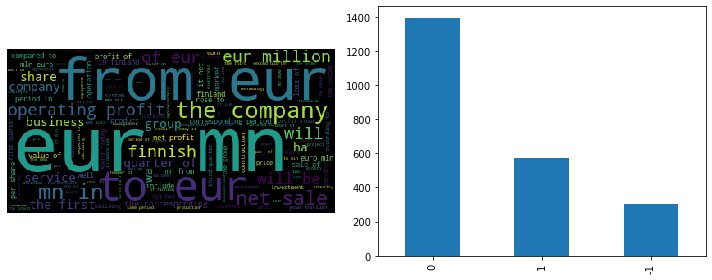

In [11]:
EDA(data3)

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2

tfidf = TfidfVectorizer(sublinear_tf=True, 
                        min_df=5, 
                        norm='l2', 
                        encoding='latin-1', 
                        ngram_range=(1, 2), 
                        stop_words='english')
features = tfidf.fit_transform(data3.contexts.apply(lambda x: ' '.join(x))).toarray()
labels = data3.labels

In [13]:
N = 10
for category_id in sorted(labels.unique()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("------------- Category {} ------------".format(category_id))
    print("Most correlated unigrams:")
    print(unigrams[-N:])
    print("Most correlated bigrams:")
    print(bigrams[-N:])
    print('\n')

------------- Category -1 ------------
Most correlated unigrams:
['slipped', 'loss', 'lower', 'half', 'eur', 'profit', 'dropped', 'mn', 'fell', 'decreased']
Most correlated bigrams:
['sale fell', 'profit eur', 'profit decreased', 'fell eur', 'profit fell', 'operating loss', 'compared profit', 'sale decreased', 'eur mn', 'decreased eur']


------------- Category 0 ------------
Most correlated unigrams:
['corresponding', 'loss', 'rose', 'compared', 'operating', 'net', 'period', 'profit', 'mn', 'eur']
Most correlated bigrams:
['profit rose', 'net sale', 'net profit', 'mn corresponding', 'eur eur', 'rose eur', 'corresponding period', 'operating profit', 'mn eur', 'eur mn']


------------- Category 1 ------------
Most correlated unigrams:
['improved', 'year', 'net', 'profit', 'period', 'grew', 'increase', 'eur', 'increased', 'rose']
Most correlated bigrams:
['period increased', 'corresponding period', 'eur compared', 'eur mn', 'eur eur', 'mn eur', 'increased eur', 'operating profit', 'profi

## Sentiment Model

In [14]:
from IPython.display import display_html
def model_eval(model, X_train, X_dev, X_test, y_train, y_dev, y_test, name = 'Model'):
    print('--------------------------------------  {} --------------------------------------'.format(name))
    F1 = [model.score(X_train, y_train), model.score(X_dev, y_dev), model.score(X_test, y_test)]
    acc = [model.score(X_train, y_train, method = 'accuracy'), model.score(X_dev, y_dev, method = 'accuracy'), model.score(X_test, y_test, method = 'accuracy')]
    print("Training set F1score: ",F1[0]) 
    print("Dev set F1score: ", F1[1])
    print("Test set F1score: ", F1[2])
    def gen_confusion_matrix(pred_label, y_labels):
        from sklearn.metrics import confusion_matrix
        import seaborn as sns


        conf_mat = confusion_matrix(y_labels, pred_label)
        cm = sns.light_palette("green", as_cmap=True)
        df = pd.DataFrame(conf_mat, index = ['actual_negative','actual_neutral','actual_positive'], columns = ['pred_negative','pred_neutral','pred_positive']).style.background_gradient(cmap=cm)
        


        count = np.sum(conf_mat, axis = 1)
        precision = np.diag(conf_mat) / np.sum(conf_mat, axis = 0)
        recall = np.diag(conf_mat) / np.sum(conf_mat, axis = 1)
        f1score = 2 * precision * recall / (precision + recall)
        #weighted_avg = [np.average(precision, weights = count), np.average(recall, weights = count), np.average(f1score, weights = count)]
        macro_avg = [np.average(precision), np.average(recall), np.average(f1score)]

        result = pd.DataFrame([precision, recall, f1score, count], index = ['precision','recall','f1score','count'], columns = ['negative','neutral','positive']).T
        macro_avg = pd.Series(macro_avg + [np.NaN], result.columns )
        #weighted_avg = pd.Series(weighted_avg + [np.NaN], result.columns )
        result.loc['macro_avg',:] = macro_avg
        #result.loc['weighted_avg',:] = weighted_avg
        result = result.round(2).style.highlight_max( axis = 0, color = 'green')
    
        return result, df

    result, df = gen_confusion_matrix(model.predict(X_train), y_train)
    print('------------  Train Confusion Matirx ------------')
    display_side_by_side(result.render(), df.render())    
    result, df = gen_confusion_matrix(model.predict(X_dev), y_dev)
    print('------------  Dev Confusion Matirx ------------')
    display_side_by_side(result.render(), df.render())
    result, df = gen_confusion_matrix(model.predict(X_test), y_test)
    print('------------  Test Confusion Matirx ------------')
    display_side_by_side(result.render(), df.render())
    return F1 + acc
def performance_compare_plot(perf):
    import seaborn as sns
#     metrics = ['train_acc','val_acc','test_acc']
#     fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = [5 * 3, 4], sharey = True)
#     for idx, metric in enumerate(metrics):
#         data = perf[['model_name','feature_method', metric]]
#         sns.boxplot( x= 'model_name', y = metric, data = data, ax = axes[idx])
#         chart = sns.stripplot(x = 'model_name', y = metric, data = data, size=8, jitter=True, edgecolor="gray", linewidth=2, ax = axes[idx])
#         axes[idx].set_xticklabels(chart.get_xticklabels(), rotation=45, color = 'white')
#         axes[idx].set_title(metric, color = 'white')
#         axes[idx].tick_params(labelcolor = 'white')
#     plt.tight_layout()
#     plt.show()

    metrics = ['train_f1','val_f1','test_f1']
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = [5 * 3, 4], sharey = True)
    for idx, metric in enumerate(metrics):
        data = perf[['model_name','feature_method', metric]]
        sns.boxplot( x= 'model_name', y = metric, data = data, ax = axes[idx])
        chart = sns.stripplot(x = 'model_name', y = metric, data = data, size=8, jitter=True, edgecolor="gray", linewidth=2, ax = axes[idx])
        axes[idx].set_xticklabels(chart.get_xticklabels(), rotation=45, color = 'white')
        axes[idx].set_title(metric, color = 'white')
        axes[idx].tick_params(labelcolor = 'white')
    plt.tight_layout()
    plt.show()

In [15]:
from sklearn.metrics import f1_score

In [16]:
from scipy.sparse import dok_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from collections import Counter
class SentimentClassifier:
    def __init__(self, feature_method, model = LogisticRegression(C=1.0), min_feature_ct = 10):
        # min_feature_ct: int, ignore the features appear less than this number to avoid overfitting
        self.word2idx = {}
        self.idx2word = {}
        self.feature_method = feature_method
        self.min_feature_ct = min_feature_ct
        #self.L2_reg = L2_reg
        self.model = model
    def pipeline(self, X, training = False):
        """
        input:
            - X: featurized input
        output:
            2d sparse matrix
        """
        
        # Build feature_vocab during training
        if training:
            fea_ct = Counter([word for sent in X for word in self.feature_method(sent)])
            fea_ct = {key: val for key, val in fea_ct.items() if val >= self.min_feature_ct}

            self.word2idx = {key: idx + 1 for idx, key in enumerate(list(fea_ct.keys()))}
            #idx2word = {idx + 1: key for idx, key in enumerate(list(fea_ct.keys()))}
            self.word2idx['_unknown_'] = 0
            #idx2word[0] = '_unknown_'

        #text_encoded = [[self.word2idx.get(word, 0) for word in self.feature_method(sent)] for sent in X]
        #print(text_encoded)
        sp_matrix = dok_matrix((len(X), len(self.word2idx)))
        for nrow, sent in enumerate(X):
            feat = self.feature_method(sent)
            for key, val in feat.items():
                # print(nrow, key, val)
                sp_matrix[nrow, self.word2idx.get(key, 0 )] = val
        return sp_matrix    
    def fit(self, X, y):
        X= self.pipeline(X, training = True)
        weight_dict = compute_class_weight(y)
        self.model.fit(X,y, sample_weight = [weight_dict.get(label) for label in y])
        return self
    def predict(self, X):
        X = self.pipeline(X, training = False)
        return self.model.predict(X)
    def score(self, X, y, method = 'F1-score'):
        pred_y = self.predict(X)
        if method == 'F1-score':
            #X= self.pipeline(X, training = False)
            #return self.model.score(X, y) 
            #weight_dict = compute_class_weight(y)
            #return f1_score(y, pred_y, sample_weight = [weight_dict.get(label) for label in y])
            return f1_score(y, pred_y, average = 'macro')
        elif method == 'accuracy':
            X= self.pipeline(X, training = False)
            return self.model.score(X, y) 

In [17]:
def BOW_featurizer(text):
    from collections import Counter
    """
    input:
        - text: a list of tokens (str or int)
    output:
        dictionary of {token: count}
    """
    return Counter(text)    
from nltk.util import pad_sequence
from nltk.util import everygrams, ngrams
def everyGram(text, N = 5):
    return Counter(list(everygrams(list(pad_sequence(text,
            pad_left = True, left_pad_symbol = '<s>',
            pad_right = True, right_pad_symbol = '<s>',
            n= N)),
            max_len = N))) 
def NGram(text, N = 5):
    return Counter(list(ngrams(list(pad_sequence(text,
        pad_left = True, left_pad_symbol = '<s>',
        pad_right = True, right_pad_symbol = '<s>',
        n= N)),
        n = N)))

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
def compute_class_weight(y):
    """
    n_samples / (n_classes * n_samples_with_class)
    """
    ct = Counter(y)
    n_classes = len(ct.keys())
    n_samples = np.sum(np.array(list(ct.values())))
    weights = n_samples / (n_classes * np.array(list(ct.values())))
    weight = {}
    for i, label in enumerate(ct.keys()):
        weight[label] = weights[i]

    return weight


In [20]:
model = LogisticRegression(C=1.0)

model_list = {'randomForest':RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
          'LinearSVC':LinearSVC(),
          'MultinomialNB':MultinomialNB(  ),
          'LogisticRegression':LogisticRegression(C=1.0, tol=1e-4, random_state=0, solver='lbfgs', multi_class='auto'),
             }
# , class_weight = 'balanced'

#### textfile4

In [21]:
feature_method_list = {'BOW': BOW_featurizer, 'everyGram':everyGram}
perf = []
for model_name, model in model_list.items():
    print('---------------------------------------------- {} ------------------------------------------------'.format(model_name))
    for feature_method_name, feature_method in feature_method_list.items():
        cls = SentimentClassifier(model = model, feature_method=feature_method, min_feature_ct = 10)
        cls = cls.fit(X_train, y_train)
        train_f1 , val_f1 , test_f1, train_acc , val_acc , test_acc  = model_eval(cls, X_train, X_dev, X_test, y_train, y_dev, y_test, name = feature_method_name)
        perf += [[model_name, feature_method_name,train_acc, train_f1 , val_acc, val_f1 , test_acc, test_f1 ]]
perf = pd.DataFrame(perf, columns = ['model_name','feature_method','train_acc','train_f1','val_acc','val_f1','test_acc','test_f1'])

---------------------------------------------- randomForest ------------------------------------------------
--------------------------------------  BOW --------------------------------------
Training set F1score:  0.7735602342877267
Dev set F1score:  0.7763720658457501
Test set F1score:  0.7090745476934736
------------  Train Confusion Matirx ------------


precision recall f1score count 
 
 negative 
 0.74 
 0.71 
 0.73 
 253 
 
 
 neutral 
 0.82 
 0.98 
 0.9 
 1095 
 
 
 positive 
 0.96 
 0.55 
 0.7 
 463 
 
 
 macro_avg 
 0.84 
 0.75 
 0.77 
 nan 
 
 pred_negative pred_neutral pred_positive 
 
 actual_negative 
 180 
 64 
 9 
 
 
 actual_neutral 
 20 
 1073 
 2 
 
 
 actual_positive 
 43 
 165 
 255

------------  Dev Confusion Matirx ------------


precision recall f1score count 
 
 negative 
 0.72 
 0.75 
 0.74 
 28 
 
 
 neutral 
 0.84 
 0.99 
 0.91 
 136 
 
 
 positive 
 0.92 
 0.55 
 0.69 
 62 
 
 
 macro_avg 
 0.83 
 0.76 
 0.78 
 nan 
 
 pred_negative pred_neutral pred_positive 
 
 actual_negative 
 21 
 5 
 2 
 
 
 actual_neutral 
 1 
 134 
 1 
 
 
 actual_positive 
 7 
 21 
 34

------------  Test Confusion Matirx ------------


precision recall f1score count 
 
 negative 
 0.57 
 0.59 
 0.58 
 22 
 
 
 neutral 
 0.86 
 0.97 
 0.91 
 160 
 
 
 positive 
 0.92 
 0.49 
 0.64 
 45 
 
 
 macro_avg 
 0.78 
 0.68 
 0.71 
 nan 
 
 pred_negative pred_neutral pred_positive 
 
 actual_negative 
 13 
 7 
 2 
 
 
 actual_neutral 
 5 
 155 
 0 
 
 
 actual_positive 
 5 
 18 
 22

--------------------------------------  everyGram --------------------------------------
Training set F1score:  0.7316937016307818
Dev set F1score:  0.7585716969611572
Test set F1score:  0.6815289591180932
------------  Train Confusion Matirx ------------


precision recall f1score count 
 
 negative 
 0.81 
 0.59 
 0.68 
 253 
 
 
 neutral 
 0.79 
 0.98 
 0.88 
 1095 
 
 
 positive 
 0.88 
 0.5 
 0.64 
 463 
 
 
 macro_avg 
 0.82 
 0.69 
 0.73 
 nan 
 
 pred_negative pred_neutral pred_positive 
 
 actual_negative 
 150 
 83 
 20 
 
 
 actual_neutral 
 6 
 1076 
 13 
 
 
 actual_positive 
 30 
 202 
 231

------------  Dev Confusion Matirx ------------


precision recall f1score count 
 
 negative 
 0.75 
 0.75 
 0.75 
 28 
 
 
 neutral 
 0.81 
 0.99 
 0.89 
 136 
 
 
 positive 
 0.94 
 0.48 
 0.64 
 62 
 
 
 macro_avg 
 0.83 
 0.74 
 0.76 
 nan 
 
 pred_negative pred_neutral pred_positive 
 
 actual_negative 
 21 
 6 
 1 
 
 
 actual_neutral 
 1 
 134 
 1 
 
 
 actual_positive 
 6 
 26 
 30

------------  Test Confusion Matirx ------------


precision recall f1score count 
 
 negative 
 0.73 
 0.5 
 0.59 
 22 
 
 
 neutral 
 0.85 
 0.96 
 0.9 
 160 
 
 
 positive 
 0.68 
 0.47 
 0.55 
 45 
 
 
 macro_avg 
 0.75 
 0.64 
 0.68 
 nan 
 
 pred_negative pred_neutral pred_positive 
 
 actual_negative 
 11 
 7 
 4 
 
 
 actual_neutral 
 1 
 153 
 6 
 
 
 actual_positive 
 3 
 21 
 21

---------------------------------------------- LinearSVC ------------------------------------------------


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--------------------------------------  BOW --------------------------------------
Training set F1score:  0.9776758119702503
Dev set F1score:  0.8161912453251036
Test set F1score:  0.8340600468920404
------------  Train Confusion Matirx ------------


precision recall f1score count 
 
 negative 
 0.98 
 0.96 
 0.97 
 253 
 
 
 neutral 
 0.99 
 1 
 0.99 
 1095 
 
 
 positive 
 0.98 
 0.96 
 0.97 
 463 
 
 
 macro_avg 
 0.98 
 0.97 
 0.98 
 nan 
 
 pred_negative pred_neutral pred_positive 
 
 actual_negative 
 242 
 4 
 7 
 
 
 actual_neutral 
 0 
 1094 
 1 
 
 
 actual_positive 
 5 
 12 
 446

------------  Dev Confusion Matirx ------------


precision recall f1score count 
 
 negative 
 0.79 
 0.68 
 0.73 
 28 
 
 
 neutral 
 0.93 
 0.93 
 0.93 
 136 
 
 
 positive 
 0.77 
 0.81 
 0.79 
 62 
 
 
 macro_avg 
 0.83 
 0.81 
 0.82 
 nan 
 
 pred_negative pred_neutral pred_positive 
 
 actual_negative 
 19 
 1 
 8 
 
 
 actual_neutral 
 2 
 127 
 7 
 
 
 actual_positive 
 3 
 9 
 50

------------  Test Confusion Matirx ------------


precision recall f1score count 
 
 negative 
 0.77 
 0.77 
 0.77 
 22 
 
 
 neutral 
 0.94 
 0.92 
 0.93 
 160 
 
 
 positive 
 0.77 
 0.82 
 0.8 
 45 
 
 
 macro_avg 
 0.83 
 0.84 
 0.83 
 nan 
 
 pred_negative pred_neutral pred_positive 
 
 actual_negative 
 17 
 3 
 2 
 
 
 actual_neutral 
 3 
 148 
 9 
 
 
 actual_positive 
 2 
 6 
 37

--------------------------------------  everyGram --------------------------------------
Training set F1score:  0.9991877964610701
Dev set F1score:  0.8045123935796633
Test set F1score:  0.7997288871710335
------------  Train Confusion Matirx ------------


precision recall f1score count 
 
 negative 
 1 
 1 
 1 
 253 
 
 
 neutral 
 1 
 1 
 1 
 1095 
 
 
 positive 
 1 
 1 
 1 
 463 
 
 
 macro_avg 
 1 
 1 
 1 
 nan 
 
 pred_negative pred_neutral pred_positive 
 
 actual_negative 
 252 
 1 
 0 
 
 
 actual_neutral 
 0 
 1095 
 0 
 
 
 actual_positive 
 0 
 0 
 463

------------  Dev Confusion Matirx ------------


precision recall f1score count 
 
 negative 
 0.67 
 0.79 
 0.72 
 28 
 
 
 neutral 
 0.91 
 0.93 
 0.92 
 136 
 
 
 positive 
 0.83 
 0.73 
 0.78 
 62 
 
 
 macro_avg 
 0.8 
 0.81 
 0.8 
 nan 
 
 pred_negative pred_neutral pred_positive 
 
 actual_negative 
 22 
 3 
 3 
 
 
 actual_neutral 
 4 
 126 
 6 
 
 
 actual_positive 
 7 
 10 
 45

------------  Test Confusion Matirx ------------


precision recall f1score count 
 
 negative 
 0.79 
 0.68 
 0.73 
 22 
 
 
 neutral 
 0.93 
 0.93 
 0.93 
 160 
 
 
 positive 
 0.72 
 0.76 
 0.74 
 45 
 
 
 macro_avg 
 0.81 
 0.79 
 0.8 
 nan 
 
 pred_negative pred_neutral pred_positive 
 
 actual_negative 
 15 
 4 
 3 
 
 
 actual_neutral 
 1 
 149 
 10 
 
 
 actual_positive 
 3 
 8 
 34

---------------------------------------------- MultinomialNB ------------------------------------------------
--------------------------------------  BOW --------------------------------------
Training set F1score:  0.8140686564173447
Dev set F1score:  0.7672484739481141
Test set F1score:  0.691068006055589
------------  Train Confusion Matirx ------------


precision recall f1score count 
 
 negative 
 0.7 
 0.85 
 0.77 
 253 
 
 
 neutral 
 0.9 
 0.92 
 0.91 
 1095 
 
 
 positive 
 0.84 
 0.7 
 0.76 
 463 
 
 
 macro_avg 
 0.81 
 0.82 
 0.81 
 nan 
 
 pred_negative pred_neutral pred_positive 
 
 actual_negative 
 215 
 24 
 14 
 
 
 actual_neutral 
 42 
 1005 
 48 
 
 
 actual_positive 
 49 
 89 
 325

------------  Dev Confusion Matirx ------------


precision recall f1score count 
 
 negative 
 0.64 
 0.82 
 0.72 
 28 
 
 
 neutral 
 0.87 
 0.91 
 0.89 
 136 
 
 
 positive 
 0.79 
 0.61 
 0.69 
 62 
 
 
 macro_avg 
 0.77 
 0.78 
 0.77 
 nan 
 
 pred_negative pred_neutral pred_positive 
 
 actual_negative 
 23 
 3 
 2 
 
 
 actual_neutral 
 4 
 124 
 8 
 
 
 actual_positive 
 9 
 15 
 38

------------  Test Confusion Matirx ------------


precision recall f1score count 
 
 negative 
 0.48 
 0.55 
 0.51 
 22 
 
 
 neutral 
 0.9 
 0.89 
 0.9 
 160 
 
 
 positive 
 0.67 
 0.67 
 0.67 
 45 
 
 
 macro_avg 
 0.68 
 0.7 
 0.69 
 nan 
 
 pred_negative pred_neutral pred_positive 
 
 actual_negative 
 12 
 5 
 5 
 
 
 actual_neutral 
 8 
 142 
 10 
 
 
 actual_positive 
 5 
 10 
 30

--------------------------------------  everyGram --------------------------------------
Training set F1score:  0.7566607311789021
Dev set F1score:  0.7490046902725719
Test set F1score:  0.628073450496179
------------  Train Confusion Matirx ------------


precision recall f1score count 
 
 negative 
 0.69 
 0.68 
 0.69 
 253 
 
 
 neutral 
 0.83 
 0.97 
 0.89 
 1095 
 
 
 positive 
 0.89 
 0.56 
 0.69 
 463 
 
 
 macro_avg 
 0.8 
 0.74 
 0.76 
 nan 
 
 pred_negative pred_neutral pred_positive 
 
 actual_negative 
 172 
 61 
 20 
 
 
 actual_neutral 
 26 
 1057 
 12 
 
 
 actual_positive 
 51 
 151 
 261

------------  Dev Confusion Matirx ------------


precision recall f1score count 
 
 negative 
 0.62 
 0.82 
 0.71 
 28 
 
 
 neutral 
 0.84 
 0.97 
 0.9 
 136 
 
 
 positive 
 0.94 
 0.48 
 0.64 
 62 
 
 
 macro_avg 
 0.8 
 0.76 
 0.75 
 nan 
 
 pred_negative pred_neutral pred_positive 
 
 actual_negative 
 23 
 4 
 1 
 
 
 actual_neutral 
 3 
 132 
 1 
 
 
 actual_positive 
 11 
 21 
 30

------------  Test Confusion Matirx ------------


precision recall f1score count 
 
 negative 
 0.42 
 0.45 
 0.43 
 22 
 
 
 neutral 
 0.86 
 0.94 
 0.9 
 160 
 
 
 positive 
 0.71 
 0.44 
 0.55 
 45 
 
 
 macro_avg 
 0.66 
 0.61 
 0.63 
 nan 
 
 pred_negative pred_neutral pred_positive 
 
 actual_negative 
 10 
 6 
 6 
 
 
 actual_neutral 
 7 
 151 
 2 
 
 
 actual_positive 
 7 
 18 
 20

---------------------------------------------- LogisticRegression ------------------------------------------------


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


--------------------------------------  BOW --------------------------------------
Training set F1score:  0.9561512595120402
Dev set F1score:  0.8404677130560483
Test set F1score:  0.808876811594203
------------  Train Confusion Matirx ------------


precision recall f1score count 
 
 negative 
 0.92 
 0.98 
 0.95 
 253 
 
 
 neutral 
 0.99 
 0.97 
 0.98 
 1095 
 
 
 positive 
 0.95 
 0.94 
 0.94 
 463 
 
 
 macro_avg 
 0.95 
 0.96 
 0.96 
 nan 
 
 pred_negative pred_neutral pred_positive 
 
 actual_negative 
 248 
 2 
 3 
 
 
 actual_neutral 
 8 
 1065 
 22 
 
 
 actual_positive 
 15 
 13 
 435

------------  Dev Confusion Matirx ------------


precision recall f1score count 
 
 negative 
 0.76 
 0.79 
 0.77 
 28 
 
 
 neutral 
 0.94 
 0.9 
 0.92 
 136 
 
 
 positive 
 0.8 
 0.85 
 0.83 
 62 
 
 
 macro_avg 
 0.83 
 0.85 
 0.84 
 nan 
 
 pred_negative pred_neutral pred_positive 
 
 actual_negative 
 22 
 1 
 5 
 
 
 actual_neutral 
 5 
 123 
 8 
 
 
 actual_positive 
 2 
 7 
 53

------------  Test Confusion Matirx ------------


precision recall f1score count 
 
 negative 
 0.71 
 0.77 
 0.74 
 22 
 
 
 neutral 
 0.94 
 0.89 
 0.92 
 160 
 
 
 positive 
 0.73 
 0.82 
 0.77 
 45 
 
 
 macro_avg 
 0.79 
 0.83 
 0.81 
 nan 
 
 pred_negative pred_neutral pred_positive 
 
 actual_negative 
 17 
 3 
 2 
 
 
 actual_neutral 
 5 
 143 
 12 
 
 
 actual_positive 
 2 
 6 
 37

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


--------------------------------------  everyGram --------------------------------------
Training set F1score:  0.9896894185407573
Dev set F1score:  0.7986214759535654
Test set F1score:  0.7962419828394913
------------  Train Confusion Matirx ------------


precision recall f1score count 
 
 negative 
 0.99 
 1 
 0.99 
 253 
 
 
 neutral 
 0.99 
 0.99 
 0.99 
 1095 
 
 
 positive 
 0.98 
 0.98 
 0.98 
 463 
 
 
 macro_avg 
 0.99 
 0.99 
 0.99 
 nan 
 
 pred_negative pred_neutral pred_positive 
 
 actual_negative 
 252 
 1 
 0 
 
 
 actual_neutral 
 1 
 1085 
 9 
 
 
 actual_positive 
 1 
 6 
 456

------------  Dev Confusion Matirx ------------


precision recall f1score count 
 
 negative 
 0.64 
 0.82 
 0.72 
 28 
 
 
 neutral 
 0.92 
 0.9 
 0.91 
 136 
 
 
 positive 
 0.79 
 0.74 
 0.77 
 62 
 
 
 macro_avg 
 0.79 
 0.82 
 0.8 
 nan 
 
 pred_negative pred_neutral pred_positive 
 
 actual_negative 
 23 
 2 
 3 
 
 
 actual_neutral 
 5 
 122 
 9 
 
 
 actual_positive 
 8 
 8 
 46

------------  Test Confusion Matirx ------------


precision recall f1score count 
 
 negative 
 0.76 
 0.73 
 0.74 
 22 
 
 
 neutral 
 0.93 
 0.91 
 0.92 
 160 
 
 
 positive 
 0.69 
 0.76 
 0.72 
 45 
 
 
 macro_avg 
 0.8 
 0.8 
 0.8 
 nan 
 
 pred_negative pred_neutral pred_positive 
 
 actual_negative 
 16 
 4 
 2 
 
 
 actual_neutral 
 1 
 146 
 13 
 
 
 actual_positive 
 4 
 7 
 34

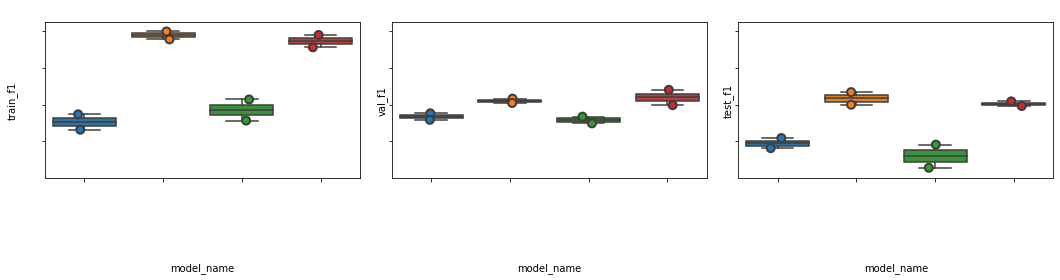

In [22]:
performance_compare_plot(perf)

In [23]:
perf['model_name'] = perf['model_name'] + '_' + perf['feature_method']
perf.pop('feature_method')
perf.set_index('model_name').style.highlight_max( axis = 0, color = 'green')

,train_acc,train_f1,val_acc,val_f1,test_acc,test_f1
model_name,,,,,,
randomForest_BOW,0.832689,0.77356,0.836283,0.776372,0.837004,0.709075
randomForest_everyGram,0.804528,0.731694,0.818584,0.758572,0.814978,0.681529
LinearSVC_BOW,0.983987,0.977676,0.867257,0.816191,0.889868,0.83406
LinearSVC_everyGram,0.999448,0.999188,0.853982,0.804512,0.872247,0.799729
MultinomialNB_BOW,0.85312,0.814069,0.818584,0.767248,0.810573,0.691068
MultinomialNB_everyGram,0.82275,0.756661,0.818584,0.749005,0.797357,0.628073
LogisticRegression_BOW,0.965213,0.956151,0.876106,0.840468,0.867841,0.808877
LogisticRegression_everyGram,0.990061,0.989689,0.845133,0.798621,0.863436,0.796242


In [24]:
perf.to_csv('perf.csv')

In [ ]:
# tmp_perf = pd.read_csv('perf.csv', index_col = 0)
tmp_perf = tmp_perf.sort_values('test_f1', ascending = False)
#.style.hightlight_max(axis = 0, color = 'green')
tmp_perf.set_index('model_name').style.highlight_max( axis = 0, color = 'green')

In [ ]:
tmp = tmp_perf[:4].reset_index()

In [ ]:
tmp.reset_index()['model_name'].values

In [ ]:
tmp.model_name = ['BI_LSTM_auc', 'LogReg_everyGram', 'CNN_acc',
       'LogReg_BOW']

In [ ]:
performance_compare_plot(tmp)

## Embedding models

In [9]:

# Keras
#from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, Bidirectional, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.metrics import AUC
from keras.callbacks import EarlyStopping
## Plotly
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
# Others
import nltk
import string
import numpy as np
import pandas as pd
from nltk.corpus import stopwords

from sklearn.manifold import TSNE
from collections import Counter

/opt/anaconda3/lib/python3.7/site-packages/IPython/utils/traitlets.py:5: UserWarning:

IPython.utils.traitlets has moved to a top-level traitlets package.



In [10]:
### Create sequence
max_vocab_size = 20000
max_sent_length = 109  # changed in version 2
embedding_dim = 100  
max_sent_length3 = 80   # newly added in version 2
hidden_dim = 256
n_epoches = 100
min_token_ct = 10

### Create sequence
max_vocab_size = 20000
max_sent_length = 109  # note this difference here from the previous version
max_sent_length3 = 80  # newly added
embedding_dim = 100
hidden_dim = 256
n_epoches = 100
min_token_ct = 10

In [11]:
class Tokenizer():
    def __init__(self, min_token_ct):
        print('Initialize tokenizer')
        self.word_index = {}
        self.min_token_ct = min_token_ct
        self.vocab = None
        
        self.UNK='unknown'
        self.PAD='_pad_'
    def fit_on_texts(self,X):
        """
        For given training data, list of vocabulary list, i.g.
        [["this", "set", "1"],
         ["this", "is", "another", "set"],
         ]

        return the vocab list and rev_vocab dictionary
        2 numerical encodings are reserved: {PAD:0,UNK:1}
        """

        
        token_ct = Counter([word for sent in X for word in sent])
        token_ct = {k: v for k, v in token_ct.items() if v >= self.min_token_ct}
        vocab = sorted(token_ct, key=token_ct.get, reverse=True)
        vocab = [self.PAD,self.UNK] + vocab

        word2idx = {word: idx for idx, word in enumerate(vocab)}
        idx2word = {idx: word for idx, word in enumerate(vocab)}
        self.vocab = vocab
        self.word_index = word2idx
    def texts_to_sequences(self,X):
        """
        For given training data, list of vocabulary list, i.g.
        [["this", "set", "1"],
         ["this", "is", "another", "set"],
        ]
        """
        assert(len(self.word_index) > 0 )
        UNK_idx = self.word_index.get(self.UNK)
        return [[self.word_index.get(word, UNK_idx) for word in sent] for sent in X ]     

In [12]:
tokenizer3 = Tokenizer(min_token_ct)
tokenizer3.fit_on_texts(X_train)
vocabulary_size3 = len(tokenizer3.vocab) 

print([ vocabulary_size3])

Initialize tokenizer
[499]


In [13]:
X_cod_train = pad_sequences(tokenizer3.texts_to_sequences(X_train), maxlen=max_sent_length3, padding = 'post' )
X_cod_dev = pad_sequences(tokenizer3.texts_to_sequences(X_dev), maxlen=max_sent_length3, padding = 'post' )
X_cod_test = pad_sequences(tokenizer3.texts_to_sequences(X_test), maxlen=max_sent_length3, padding = 'post' )

In [14]:
from IPython.display import display_html
def bias_var_tradeoff_plot(history):
    metrics = list(history.history.keys())
    length = len(metrics)
    metrics = metrics[- int(length / 2):]
    length = len(metrics)
    
    fig, axes = plt.subplots(nrows = 1, ncols = length, figsize = [5 * length,4])
    for i, ax in enumerate(axes):
        ax.set_title(metrics[i], color = 'white')
        ax.plot(history.history[metrics[i]], label='train')
        ax.plot(history.history['val_' +metrics[i]], label='validation')

    plt.legend()
    plt.show()
def model_eval(model, history, X_train, y_train_labels, X_dev, y_dev_labels, X_test, y_test, y_test_labels, model_name = None):
    test_accr = model.evaluate(X_test, y_test)
    test_acc = test_accr[1]
    print('\n')
    print('----------------------- {}: Test_Loss: {:0.3f} Test_Accuracy: {:0.3f} -----------------------'.format(model_name, test_accr[0],test_accr[1]))
    
    #accuracy = [history.history['accuracy'][-1], history.history['val_accuracy'][-1], test_accr[1]]
    #loss = [history.history['loss'][-1], history.history['val_loss'][-1], test_accr[0]]
    

    def gen_confusion_matrix(y_pred, y_labels):
        from sklearn.metrics import confusion_matrix
        import seaborn as sns
        pred_label = []
        for pred in y_pred:
            if np.argmax(pred) == 0:
                pred_label += [0]
            elif np.argmax(pred) == 1:
                pred_label += [1]
            elif np.argmax(pred) == 2:
                pred_label += [-1]


        conf_mat = confusion_matrix(y_labels, pred_label)
        cm = sns.light_palette("green", as_cmap=True)
        df = pd.DataFrame(conf_mat, index = ['actual_negative','actual_neutral','actual_positive'], columns = ['pred_negative','pred_neutral','pred_positive']).style.background_gradient(cmap=cm)
        print('Confusion Matirx')


        count = np.sum(conf_mat, axis = 1)
        precision = np.diag(conf_mat) / np.sum(conf_mat, axis = 0)
        recall = np.diag(conf_mat) / np.sum(conf_mat, axis = 1)
        f1score = 2 * precision * recall / (precision + recall)
        weighted_avg = [np.average(precision, weights = count), np.average(recall, weights = count), np.average(f1score, weights = count)]
        macro_avg = [np.average(precision), np.average(recall), np.average(f1score)]

        result = pd.DataFrame([precision, recall, f1score, count], index = ['precision','recall','f1score','count'], columns = ['negative','neutral','positive']).T
        macro_avg = pd.Series(macro_avg + [np.NaN], result.columns )
        #weighted_avg = pd.Series(weighted_avg + [np.NaN], result.columns )
        result.loc['macro_avg',:] = macro_avg
        #result.loc['weighted_avg',:] = weighted_avg
        result = result.round(2).style.highlight_max( axis = 0, color = 'green')
        
        return result, df, macro_avg[2]
    print('------------  Train Confusion Matirx ------------')
    result, df, train_f1 = gen_confusion_matrix(model.predict(X_train), y_train_labels)
    display_side_by_side(result.render(), df.render())
    print('------------  Dev Confusion Matirx ------------')
    result, df, dev_f1 = gen_confusion_matrix(model.predict(X_dev), y_dev_labels)
    display_side_by_side(result.render(), df.render())
    print('------------  Test Confusion Matirx ------------')
    result, df, test_f1 = gen_confusion_matrix(model.predict(X_test), y_test_labels)
    display_side_by_side(result.render(), df.render())
    
    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]
    
    return train_acc, train_f1 , val_acc, dev_f1 , test_acc, test_f1
def performance_compare_plot(perf):
    import seaborn as sns
    metrics = ['train_acc','val_acc','test_acc']
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = [5 * 3, 4], sharey = True)
    for idx, metric in enumerate(metrics):
        data = perf[['model_name',metric]]
        sns.boxplot( x= 'model_name', y = metric, data = data, ax = axes[idx])
        chart = sns.stripplot(x = 'model_name', y = metric, data = data, size=8, jitter=True, edgecolor="gray", linewidth=2, ax = axes[idx])
        axes[idx].set_xticklabels(chart.get_xticklabels(), rotation=60, color = 'white')
        axes[idx].set_title(metric, color = 'white')
        axes[idx].tick_params(labelcolor = 'white')
    plt.tight_layout()
    plt.show()

    metrics = ['train_f1','val_f1','test_f1']
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = [5 * 3, 4], sharey = True)
    for idx, metric in enumerate(metrics):
        data = perf[['model_name', metric]]
        sns.boxplot( x= 'model_name', y = metric, data = data, ax = axes[idx])
        chart = sns.stripplot(x = 'model_name', y = metric, data = data, size=8, jitter=True, edgecolor="gray", linewidth=2, ax = axes[idx])
        axes[idx].set_xticklabels(chart.get_xticklabels(), rotation=60, color = 'white')
        axes[idx].set_title(metric, color = 'white')
        axes[idx].tick_params(labelcolor = 'white')
    plt.tight_layout()
    plt.show()

### GLOVE

In [15]:
glove = pd.read_csv("glove_6B_100d_top100k.csv"); glove.head()

,the,",",.,of,to,and,in,a,"""",'s,...,antz,monnaie,copyist,toonami,bagration,divo,convulsive,unviable,madhava,autocephalous
0,-0.038194,-0.10767,-0.33979,-0.15290,-0.189700,-0.071953,0.085703,-0.270860,-0.30457,0.58854,...,0.175470,-0.032896,0.37886,0.339320,-0.52125,0.20375,0.42829,-0.560580,-0.26374,0.457840
1,-0.244870,0.11053,0.20941,-0.24279,0.050024,0.231270,-0.222010,0.044006,-0.23645,-0.20250,...,-0.559680,-0.721960,-0.24468,-0.266210,-1.09030,-0.07108,0.29863,-0.486880,0.20904,0.154020
2,0.728120,0.59812,0.46348,0.89837,0.190840,0.023731,0.165690,-0.020260,0.17576,0.73479,...,0.480470,-0.129030,0.45714,-0.224130,-0.66645,-0.13259,-0.15156,-0.314340,-1.12440,0.321590
3,-0.399610,-0.54361,-0.64792,0.16996,-0.049184,-0.506380,0.133730,-0.173950,-0.72854,-0.68338,...,0.287520,1.169300,0.17411,-1.158300,0.23457,0.15806,0.21284,-0.174410,0.25690,0.807420
4,0.083172,0.67396,-0.38377,0.53516,-0.089737,0.339230,0.382390,0.644400,-0.28343,-0.19675,...,-0.021609,0.335410,0.49281,-0.083679,0.36971,-0.48602,-0.13771,0.041936,-0.71330,-0.074811


In [16]:
unseen_word_list = []
embedding_matrix3 = np.zeros((vocabulary_size3, 100))
for word, index in tokenizer3.word_index.items():
    embedding_vector = glove.get(word)
    if embedding_vector is not None:
        embedding_matrix3[index] = embedding_vector
    else:
        unseen_word_list += [word]
print('{}/{}'.format(len(unseen_word_list), len(tokenizer3.word_index)))
print(unseen_word_list)

16/499
['_pad_', 'oyj', 'eurm', 'capman', 'basware', 'elcoteq', 'ruukki', 'kemira', 'outotec', 'xac', 'stockmann', 'sanoma', 'cargotec', 'okmetic', 'scanfil', 'fiskars']


In [17]:
import keras
METRICS = [
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(curve="PR", name='auc'),
    'accuracy'
]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [18]:
## Network architecture
def lstm(vocabulary_size, embedding_dim,hidden_dim, max_sent_length, embedding_matrix ):
    model = Sequential()
    model.add(Embedding(vocabulary_size, embedding_dim, input_length=max_sent_length,weights = [embedding_matrix], trainable=True))
    model.add(Dropout(0.2))
    model.add(Conv1D(64,5,activation = 'relu'))
    model.add(MaxPooling1D(pool_size = 4))
    model.add(LSTM(hidden_dim))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics= METRICS)

    model.summary()
    return model
## Network architecture
def CNN(vocabulary_size, embedding_dim, hidden_dim, max_sent_length, embedding_matrix ):
    model = Sequential()
    model.add(Embedding(vocabulary_size, embedding_dim, input_length=max_sent_length,weights = [embedding_matrix], trainable=True))
    model.add(Dropout(0.2))
    model.add(Conv1D(100,5,activation = 'tanh'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics= METRICS)

   #model.add(Conv1D(filters=100, kernel_size=3, activation="tanh", name="Conv1D-1"))


    model.summary()
    return model
## Network architecture
def bi_lstm(vocabulary_size, embedding_dim, hidden_dim, max_sent_length, embedding_matrix ):
    model = Sequential()
    model.add(Embedding(vocabulary_size, embedding_dim, input_length=max_sent_length,weights = [embedding_matrix], trainable=True))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(int(hidden_dim / 2))))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics= METRICS)

    model.summary()
    return model

model_list = {'LSTM': lstm, 'CNN': CNN, 'BI_LSTM':bi_lstm}

#### Stopby Accuracy

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)

In [ ]:
model_list = {'CNN': CNN, 'BI_LSTM':bi_lstm, 'LSTM': lstm, }

In [ ]:
model_list = {'CNN': CNN }
my_models = []
histories = []
for model_name, model in model_list.items():
    keras.backend.clear_session()
    my_model = model(vocabulary_size3, embedding_dim, hidden_dim, max_sent_length3, embedding_matrix3 )
    #weight_dict = compute_class_weight(y_train3)  # there is a typo in version 1: should be y_train3
    history = my_model.fit(X_cod_train3, y_cat_train3, validation_data = (X_cod_dev3, y_cat_dev3 ), epochs = n_epoches, callbacks=[es],
                            sample_weight = compute_sample_weight('balanced',y_cat_train3),verbose = 1)
    my_models += [my_model]
    histories += [history]
    save_object('/Users/catherinewu/Desktop/NLP20200509/models/model_stop_by_acc_{}.obj'.format(model_name), my_model)
    save_object('/Users/catherinewu/Desktop/NLP20200509/models/hist_stop_by_acc_{}.obj'.format(model_name), history)
    bias_var_tradeoff_plot(history)

In [ ]:
perf = []
for my_model, history, model_name in zip(my_models, histories, model_list.keys()):
    train_acc, train_f1 , val_acc, val_f1 , test_acc, test_f1 = model_eval(my_model, history, X_cod_train3, y_train3, X_cod_dev3, y_dev3, X_cod_test3, y_cat_test3, y_test3, model_name = model_name)
    perf += [[model_name, train_acc, train_f1 , val_acc, val_f1 , test_acc, test_f1 ]]
perf = pd.DataFrame(perf, columns = ['model_name','train_acc','train_f1','val_acc','val_f1','test_acc','test_f1'])

In [ ]:
model_list = {'BI_LSTM':bi_lstm,}
my_models = []
histories = []
for model_name, model in model_list.items():
    keras.backend.clear_session()
    my_model = model(vocabulary_size3, embedding_dim, hidden_dim, max_sent_length3, embedding_matrix3 )
    #weight_dict = compute_class_weight(y_train3)  # there is a typo in version 1: should be y_train3
    history = my_model.fit(X_cod_train3, y_cat_train3, validation_data = (X_cod_dev3, y_cat_dev3 ), epochs = n_epoches, callbacks=[es],
                            sample_weight = compute_sample_weight('balanced',y_cat_train3),verbose = 1)
    my_models += [my_model]
    histories += [history]
    save_object('/Users/catherinewu/Desktop/NLP20200509/models/model_stop_by_acc_{}.obj'.format(model_name), my_model)
    save_object('/Users/catherinewu/Desktop/NLP20200509/models/hist_stop_by_acc_{}.obj'.format(model_name), history)
    bias_var_tradeoff_plot(history)

In [ ]:
perf = []
for my_model, history, model_name in zip(my_models, histories, model_list.keys()):
    train_acc, train_f1 , val_acc, val_f1 , test_acc, test_f1 = model_eval(my_model, history, X_cod_train3, y_train3, X_cod_dev3, y_dev3, X_cod_test3, y_cat_test3, y_test3, model_name = model_name)
    perf += [[model_name, train_acc, train_f1 , val_acc, val_f1 , test_acc, test_f1 ]]
perf = pd.DataFrame(perf, columns = ['model_name','train_acc','train_f1','val_acc','val_f1','test_acc','test_f1'])

In [ ]:
tmp_perf = pd.read_csv('perf.csv', index_col = 0)
tmp_perf

In [ ]:
pd.concat([tmp_perf, perf]).to_csv('perf.csv')

In [ ]:
performance_compare_plot(tmp_perf)

#### Stop by AUC

In [20]:
es = EarlyStopping(monitor='val_auc', mode='max', verbose=1, patience=5)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 80, 100)           49900     
_________________________________________________________________
dropout_1 (Dropout)          (None, 80, 100)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 76, 100)           50100     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 100,303
Trainable params: 100,303
Non-trainable params: 0
_________________________________________________________________

Train on 1811 sampl

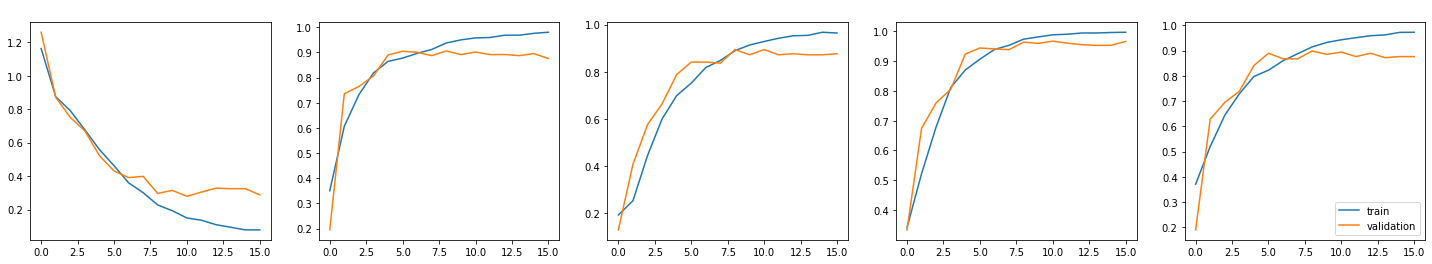

In [37]:
model_list = {'CNN_auc': CNN }
my_models = []
histories = []
for model_name, model in model_list.items():
    #keras.backend.clear_session()
    my_model = model(vocabulary_size3, embedding_dim, hidden_dim, max_sent_length3, embedding_matrix3 )
    #weight_dict = compute_class_weight(y_train3)  # there is a typo in version 1: should be y_train3
    history = my_model.fit(X_cod_train, y_cat_train, validation_data = (X_cod_dev, y_cat_dev ), epochs = n_epoches, callbacks=[es],
                            sample_weight = compute_sample_weight('balanced',y_cat_train),verbose = 1)
    my_models += [my_model]
    histories += [history]
    save_object('/Users/catherinewu/Desktop/NLP20200509/models/model_stop_by_auc_{}.obj'.format(model_name), my_model)
    save_object('/Users/catherinewu/Desktop/NLP20200509/models/hist_stop_by_auc_{}.obj'.format(model_name), history)
    
    bias_var_tradeoff_plot(history)
    

In [38]:
perf = []
for my_model, history, model_name in zip(my_models, histories, model_list.keys()):
    train_acc, train_f1 , val_acc, val_f1 , test_acc, test_f1 = model_eval(my_model, history, X_cod_train, y_train, X_cod_dev, y_dev, X_cod_test, y_cat_test, y_test, model_name = model_name)
    perf += [[model_name, train_acc, train_f1 , val_acc, val_f1 , test_acc, test_f1 ]]
perf = pd.DataFrame(perf, columns = ['model_name','train_acc','train_f1','val_acc','val_f1','test_acc','test_f1'])

227/227 [==============================] - 0s 112us/step


----------------------- CNN_auc: Test_Loss: 0.367 Test_Accuracy: 0.862 -----------------------
------------  Train Confusion Matirx ------------
Confusion Matirx


precision recall f1score count 
 
 negative 
 0.97 
 1 
 0.99 
 253 
 
 
 neutral 
 1 
 0.99 
 0.99 
 1095 
 
 
 positive 
 0.98 
 1 
 0.99 
 463 
 
 
 macro_avg 
 0.99 
 0.99 
 0.99 
 nan 
 
 pred_negative pred_neutral pred_positive 
 
 actual_negative 
 253 
 0 
 0 
 
 
 actual_neutral 
 7 
 1080 
 8 
 
 
 actual_positive 
 0 
 1 
 462

------------  Dev Confusion Matirx ------------
Confusion Matirx


precision recall f1score count 
 
 negative 
 0.71 
 0.86 
 0.77 
 28 
 
 
 neutral 
 0.93 
 0.92 
 0.93 
 136 
 
 
 positive 
 0.84 
 0.79 
 0.82 
 62 
 
 
 macro_avg 
 0.83 
 0.86 
 0.84 
 nan 
 
 pred_negative pred_neutral pred_positive 
 
 actual_negative 
 24 
 2 
 2 
 
 
 actual_neutral 
 4 
 125 
 7 
 
 
 actual_positive 
 6 
 7 
 49

------------  Test Confusion Matirx ------------
Confusion Matirx


precision recall f1score count 
 
 negative 
 0.56 
 0.68 
 0.61 
 22 
 
 
 neutral 
 0.95 
 0.9 
 0.93 
 160 
 
 
 positive 
 0.69 
 0.76 
 0.72 
 45 
 
 
 macro_avg 
 0.73 
 0.78 
 0.75 
 nan 
 
 pred_negative pred_neutral pred_positive 
 
 actual_negative 
 15 
 1 
 6 
 
 
 actual_neutral 
 7 
 144 
 9 
 
 
 actual_positive 
 5 
 6 
 34

In [39]:
tmp_perf = pd.read_csv('perf.csv', index_col = 0)
tmp_perf

,model_name,train_acc,train_f1,val_acc,val_f1,test_acc,test_f1
0,randomForest_BOW,0.832689,0.773560,0.836283,0.776372,0.837004,0.709075
1,randomForest_everyGram,0.804528,0.731694,0.818584,0.758572,0.814978,0.681529
2,LinearSVC_BOW,0.983987,0.977676,0.867257,0.816191,0.889868,0.834060
3,LinearSVC_everyGram,0.999448,0.999188,0.853982,0.804512,0.872247,0.799729
4,MultinomialNB_BOW,0.853120,0.814069,0.818584,0.767248,0.810573,0.691068
5,MultinomialNB_everyGram,0.822750,0.756661,0.818584,0.749005,0.797357,0.628073
6,LogisticRegression_BOW,0.965213,0.956151,0.876106,0.840468,0.867841,0.808877
7,LogisticRegression_everyGram,0.990061,0.989689,0.845133,0.798621,0.863436,0.796242


In [40]:
perf

,model_name,train_acc,train_f1,val_acc,val_f1,test_acc,test_f1
0,CNN_auc,0.972391,0.989785,0.876106,0.838929,0.862385,0.753898


In [41]:
pd.concat([tmp_perf, perf]).to_csv('perf.csv')

In [ ]:
performance_compare_plot(tmp_perf)


Train on 1811 samples, validate on 226 samples
Epoch 1/100
1811/1811 [==============================] - 5s 3ms/step - loss: 0.9382 - precision: 0.5461 - recall: 0.2385 - auc: 0.5017 - accuracy: 0.4451 - val_loss: 0.8197 - val_precision: 0.7033 - val_recall: 0.5664 - val_auc: 0.7466 - val_accuracy: 0.6637
Epoch 2/100
1811/1811 [==============================] - 4s 2ms/step - loss: 0.8156 - precision: 0.7081 - recall: 0.5224 - auc: 0.7193 - accuracy: 0.6516 - val_loss: 0.9890 - val_precision: 0.6243 - val_recall: 0.4779 - val_auc: 0.6754 - val_accuracy: 0.6195
Epoch 3/100
1811/1811 [==============================] - 4s 2ms/step - loss: 0.7548 - precision: 0.7531 - recall: 0.5980 - auc: 0.7736 - accuracy: 0.6858 - val_loss: 0.6829 - val_precision: 0.7795 - val_recall: 0.6726 - val_auc: 0.8181 - val_accuracy: 0.7257
Epoch 4/100
1811/1811 [==============================] - 4s 2ms/step - loss: 0.6584 - precision: 0.7955 - recall: 0.7024 - auc: 0.8512 - accuracy: 0.7537 - val_loss: 0.7018 - 

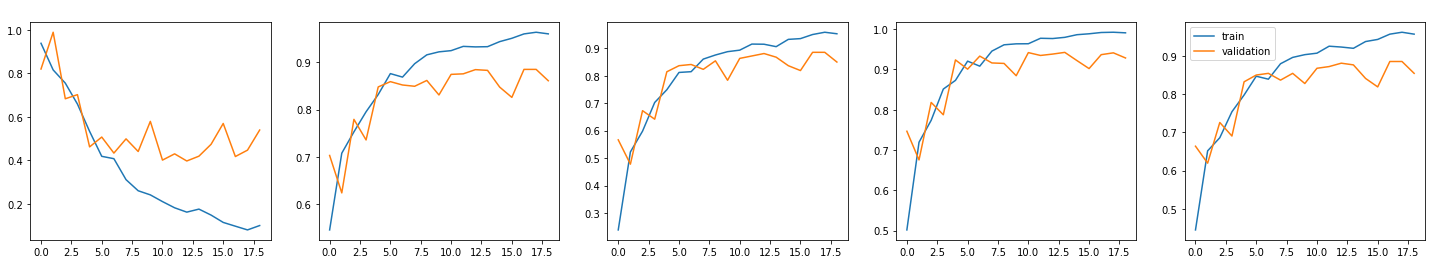

In [21]:
model_list = {'BI_LSTM_auc': bi_lstm }
my_models = []
histories = []
for model_name, model in model_list.items():
    #keras.backend.clear_session()
    my_model = model(vocabulary_size3, embedding_dim, hidden_dim, max_sent_length3, embedding_matrix3 )
    #weight_dict = compute_class_weight(y_train3)  # there is a typo in version 1: should be y_train3
    history = my_model.fit(X_cod_train, y_cat_train, validation_data = (X_cod_dev, y_cat_dev ), epochs = n_epoches, callbacks=[es],
                            sample_weight = compute_sample_weight('balanced',y_cat_train),verbose = 1)
    my_models += [my_model]
    histories += [history]
    save_object('/Users/catherinewu/Desktop/NLP20200509/models/model_stop_by_auc_{}.obj'.format(model_name), my_model)
    save_object('/Users/catherinewu/Desktop/NLP20200509/models/hist_stop_by_auc_{}.obj'.format(model_name), history)
    
    bias_var_tradeoff_plot(history)
    

In [22]:
perf = []
for my_model, history, model_name in zip(my_models, histories, model_list.keys()):
    train_acc, train_f1 , val_acc, val_f1 , test_acc, test_f1 = model_eval(my_model, history, X_cod_train, y_train, X_cod_dev, y_dev, X_cod_test, y_cat_test, y_test, model_name = model_name)
    perf += [[model_name, train_acc, train_f1 , val_acc, val_f1 , test_acc, test_f1 ]]
perf = pd.DataFrame(perf, columns = ['model_name','train_acc','train_f1','val_acc','val_f1','test_acc','test_f1'])

227/227 [==============================] - 0s 709us/step


----------------------- BI_LSTM_auc: Test_Loss: 0.442 Test_Accuracy: 0.853 -----------------------
------------  Train Confusion Matirx ------------
Confusion Matirx


precision recall f1score count 
 
 negative 
 0.94 
 1 
 0.97 
 253 
 
 
 neutral 
 1 
 0.96 
 0.98 
 1095 
 
 
 positive 
 0.94 
 0.99 
 0.96 
 463 
 
 
 macro_avg 
 0.96 
 0.98 
 0.97 
 nan 
 
 pred_negative pred_neutral pred_positive 
 
 actual_negative 
 252 
 0 
 1 
 
 
 actual_neutral 
 11 
 1054 
 30 
 
 
 actual_positive 
 4 
 1 
 458

------------  Dev Confusion Matirx ------------
Confusion Matirx


precision recall f1score count 
 
 negative 
 0.62 
 0.75 
 0.68 
 28 
 
 
 neutral 
 0.95 
 0.88 
 0.92 
 136 
 
 
 positive 
 0.79 
 0.84 
 0.81 
 62 
 
 
 macro_avg 
 0.79 
 0.82 
 0.8 
 nan 
 
 pred_negative pred_neutral pred_positive 
 
 actual_negative 
 21 
 1 
 6 
 
 
 actual_neutral 
 8 
 120 
 8 
 
 
 actual_positive 
 5 
 5 
 52

------------  Test Confusion Matirx ------------
Confusion Matirx


precision recall f1score count 
 
 negative 
 0.65 
 0.68 
 0.67 
 22 
 
 
 neutral 
 0.97 
 0.87 
 0.91 
 160 
 
 
 positive 
 0.65 
 0.87 
 0.74 
 45 
 
 
 macro_avg 
 0.76 
 0.81 
 0.77 
 nan 
 
 pred_negative pred_neutral pred_positive 
 
 actual_negative 
 15 
 1 
 6 
 
 
 actual_neutral 
 6 
 139 
 15 
 
 
 actual_positive 
 2 
 4 
 39

In [26]:
tmp_perf = pd.read_csv('perf.csv', index_col = 0)
tmp_perf

,model_name,train_acc,train_f1,val_acc,val_f1,test_acc,test_f1
0,randomForest_BOW,0.832689,0.773560,0.836283,0.776372,0.837004,0.709075
1,randomForest_everyGram,0.804528,0.731694,0.818584,0.758572,0.814978,0.681529
2,LinearSVC_BOW,0.983987,0.977676,0.867257,0.816191,0.889868,0.834060
3,LinearSVC_everyGram,0.999448,0.999188,0.853982,0.804512,0.872247,0.799729
4,MultinomialNB_BOW,0.853120,0.814069,0.818584,0.767248,0.810573,0.691068
5,MultinomialNB_everyGram,0.822750,0.756661,0.818584,0.749005,0.797357,0.628073
6,LogisticRegression_BOW,0.965213,0.956151,0.876106,0.840468,0.867841,0.808877
7,LogisticRegression_everyGram,0.990061,0.989689,0.845133,0.798621,0.863436,0.796242
0,CNN_auc,0.972391,0.989785,0.876106,0.838929,0.862385,0.753898
0,BI_LSTM_auc,0.956378,0.970627,0.853982,0.801983,0.853333,0.774666


In [24]:
perf

,model_name,train_acc,train_f1,val_acc,val_f1,test_acc,test_f1
0,BI_LSTM_auc,0.956378,0.970627,0.853982,0.801983,0.853333,0.774666


In [25]:
pd.concat([tmp_perf, perf]).to_csv('perf.csv')

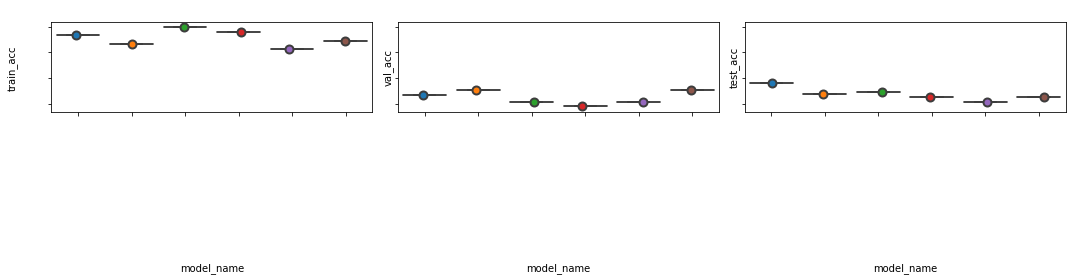

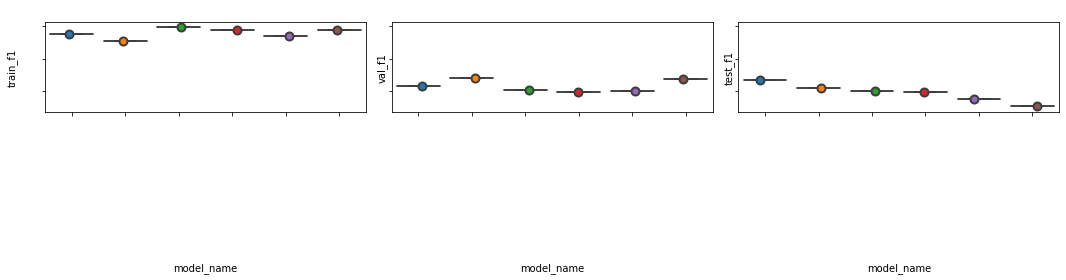

In [29]:
performance_compare_plot(tmp_perf[:6])

In [28]:
tmp_perf = tmp_perf.sort_values('test_f1', ascending = False)
#.style.hightlight_max(axis = 0, color = 'green')
tmp_perf.set_index('model_name').style.highlight_max( axis = 0, color = 'green')

,train_acc,train_f1,val_acc,val_f1,test_acc,test_f1
model_name,,,,,,
LinearSVC_BOW,0.983987,0.977676,0.867257,0.816191,0.889868,0.83406
LogisticRegression_BOW,0.965213,0.956151,0.876106,0.840468,0.867841,0.808877
LinearSVC_everyGram,0.999448,0.999188,0.853982,0.804512,0.872247,0.799729
LogisticRegression_everyGram,0.990061,0.989689,0.845133,0.798621,0.863436,0.796242
BI_LSTM_auc,0.956378,0.970627,0.853982,0.801983,0.853333,0.774666
CNN_auc,0.972391,0.989785,0.876106,0.838929,0.862385,0.753898
randomForest_BOW,0.832689,0.77356,0.836283,0.776372,0.837004,0.709075
MultinomialNB_BOW,0.85312,0.814069,0.818584,0.767248,0.810573,0.691068
randomForest_everyGram,0.804528,0.731694,0.818584,0.758572,0.814978,0.681529
